## Model with Masked inputs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
class MatchDatasetWithMask(Dataset):
    def __init__(self, df, image_folder, mask_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = str(row['Image Number']) + '.jpg'
        img_path = os.path.join(self.image_folder, img_name)
        
        # Load original image
        image = Image.open(img_path).convert('RGB')
        
        # Load or create mask
        mask_name = str(row['Image Number']) + '_mask.png'
        mask_path = os.path.join(self.mask_folder, mask_name)
        if os.path.exists(mask_path):
            # Load existing mask
            mask = Image.open(mask_path).convert('L')  # Convert to grayscale
        else:
            # Create black mask if no ball present
            mask = Image.new('L', image.size, 0)  # Black mask
        
        # Apply transforms to both image and mask
        if self.transform:
            # We need to ensure both image and mask get the same spatial transforms
            # For now, apply the same transform separately (you might want to use paired transforms)
            image = self.transform(image)
            
            # Transform for mask (without normalization)
            mask_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
            mask = mask_transform(mask)
        
        # Concatenate RGB image (3 channels) with mask (1 channel) = 4 channels total
        input_tensor = torch.cat([image, mask], dim=0)
        
        label = row['label']
        return input_tensor, label

In [3]:
class ResNet18With4Channels(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18With4Channels, self).__init__()
        
        # Load pretrained ResNet18
        self.resnet = models.resnet18(pretrained=True)
        
        # Replace first conv layer to accept 4 channels instead of 3
        self.resnet.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Initialize the new weights for the 4th channel
        with torch.no_grad():
            # Copy weights from the first 3 channels and average them for the 4th channel
            old_weights = models.resnet18(pretrained=True).conv1.weight
            new_weights = torch.zeros(64, 4, 7, 7)
            new_weights[:, :3, :, :] = old_weights
            new_weights[:, 3, :, :] = old_weights.mean(dim=1)  # Average of RGB channels
            self.resnet.conv1.weight = nn.Parameter(new_weights)
        
        # Replace the final layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)


In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, model_save_path):
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    best_val_loss = float('inf')

    print(f"Training on device: {device}")
    print(f"Input shape will be: [batch_size, 4, 224, 224]")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for i, (images, labels_batch) in enumerate(train_loader):
            images, labels_batch = images.to(device), labels_batch.to(device)

            # Print input shape once at the beginning
            if epoch == 0 and i == 0:
                print(f"Input tensor shape: {images.shape}")

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels_batch).sum().item()
            total += labels_batch.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for images, labels_batch in val_loader:
                images, labels_batch = images.to(device), labels_batch.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels_batch)

                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels_batch).sum().item()
                val_total += labels_batch.size(0)

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total * 100
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")

        # Save best model
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), model_save_path)
            print("✅ Saved new best model.")

    print("Training complete.")
    return {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    }

### Data Loading

In [22]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])

LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

# Create label mapping and convert to integers
labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)
labels = labels.drop(columns=LABELS)


In [23]:
batch_size = 32
learning_rate = 1e-3
num_epochs = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

## 1.   Ball masked inputs

In [7]:
image_path = 'data/selected_images'
mask_path = 'data/Ball_Mask'

In [8]:
# Split dataset
train_dataset, test_dataset = train_test_split(labels, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)


train_data = MatchDatasetWithMask(train_dataset, image_path, mask_path, transform)
val_data = MatchDatasetWithMask(val_dataset, image_path, mask_path, transform)
test_data = MatchDatasetWithMask(test_dataset, image_path, mask_path, transform)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [9]:
model = ResNet18With4Channels(len(LABELS))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    model_save_path='models/resnet18_ball_masked.pth'
)

Training on device: cuda:0
Input shape will be: [batch_size, 4, 224, 224]
Input tensor shape: torch.Size([32, 4, 224, 224])
[1/10] Train Loss: 0.8634, Acc: 70.01%, Val Loss: 0.6600, Acc: 77.75%
✅ Saved new best model.
[2/10] Train Loss: 0.5607, Acc: 80.82%, Val Loss: 0.6227, Acc: 77.75%
✅ Saved new best model.
[3/10] Train Loss: 0.4701, Acc: 83.42%, Val Loss: 0.7292, Acc: 78.25%
[4/10] Train Loss: 0.3574, Acc: 87.58%, Val Loss: 0.6135, Acc: 80.00%
✅ Saved new best model.
[5/10] Train Loss: 0.2860, Acc: 89.76%, Val Loss: 0.6360, Acc: 80.50%
[6/10] Train Loss: 0.2098, Acc: 92.56%, Val Loss: 0.5132, Acc: 84.88%
✅ Saved new best model.
[7/10] Train Loss: 0.1838, Acc: 93.71%, Val Loss: 0.6074, Acc: 82.25%
[8/10] Train Loss: 0.1492, Acc: 94.68%, Val Loss: 0.6199, Acc: 84.38%
[9/10] Train Loss: 0.1107, Acc: 96.40%, Val Loss: 0.6566, Acc: 85.00%
[10/10] Train Loss: 0.0916, Acc: 96.78%, Val Loss: 0.7108, Acc: 83.25%
Training complete.


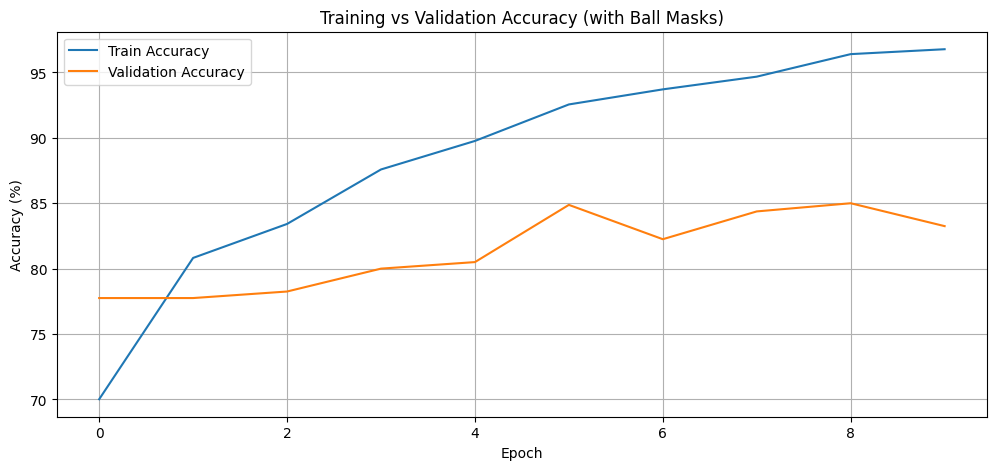

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.title("Training vs Validation Accuracy (with Ball Masks)")
plt.show()

### **Evaluation metrics**

In [ ]:
# ==== Load Best Enhanced Model ====
ballmask_model = ResNet18With4Channels(num_classes=len(LABELS))
ballmask_model.load_state_dict(torch.load('resnet18_ball_masked.pth'))
ballmask_model.to(device)
ballmask_model.eval()

# ==== Inference on Test Set ====
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [ ]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)

                        precision    recall  f1-score   support

 Start/Restar the game      0.850     0.797     0.823        64
The joy of the players      0.707     0.918     0.799       257
           yellow card      0.957     0.765     0.850       115
              Red Card      0.875     0.538     0.667        13
          Stadium View      0.885     0.920     0.902       660
         Penalty Image      0.823     0.903     0.861        72
             Free Kick      0.901     0.821     0.859       431
        Generic Moment      0.799     0.716     0.755       388

              accuracy                          0.843      2000
             macro avg      0.849     0.797     0.814      2000
          weighted avg      0.849     0.843     0.843      2000



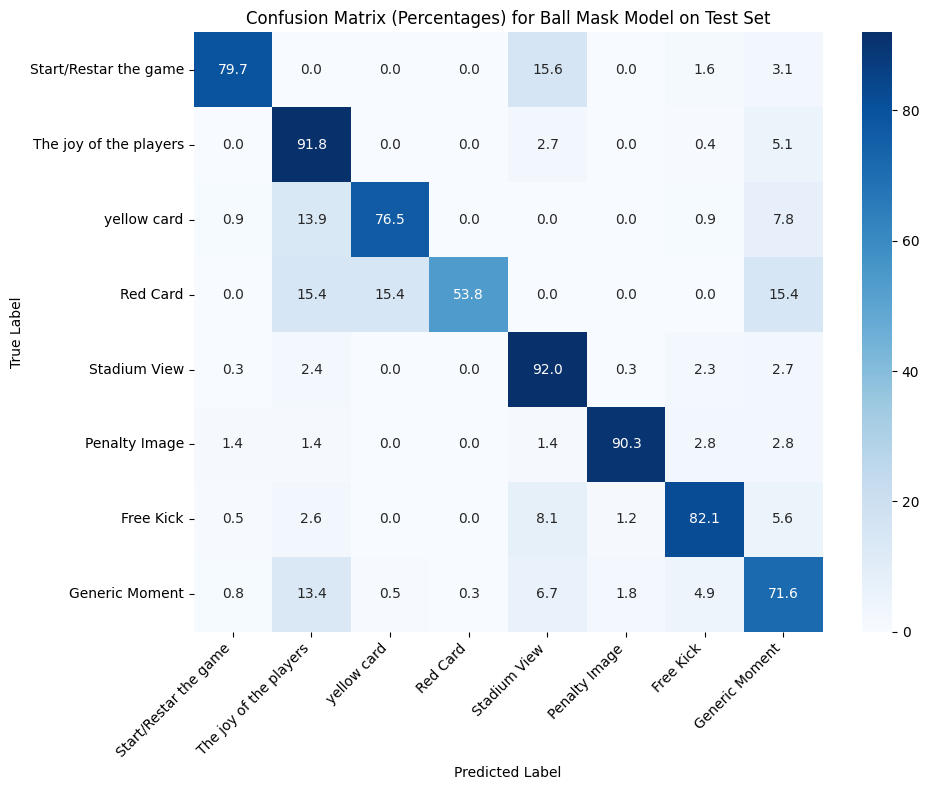

Test Accuracy: 84.30%


In [ ]:

# ==== Compute Confusion Matrix ====
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) for Ball Mask Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ==== Calculate overall accuracy ====
accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
# Convert to numpy arrays (if not already)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate per-class accuracy
class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

# Calculate class accuracies with proper handling of zero division
class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

# Calculate overall accuracy
overall_accuracy = sum(class_correct) / sum(class_total) * 100

# Print per-class accuracy as table
print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}")
print("-" * 35)
print(f"{'Overall':<25}{overall_accuracy:>9.2f}")

Class                      Accuracy
-----------------------------------
Start/Restar the game        79.69
The joy of the players       91.83
yellow card                  76.52
Red Card                     53.85
Stadium View                 91.97
Penalty Image                90.28
Free Kick                    82.13
Generic Moment               71.65
-----------------------------------
Overall                      84.30


In [ ]:
# Weighted versions
weighted_precision = precision_score(all_labels, all_preds, average='weighted')
weighted_recall = recall_score(all_labels, all_preds, average='weighted')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print weighted metrics
print(f"Accuracy: {overall_accuracy/100:.3f}")
print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall: {weighted_recall:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")


Accuracy: 0.843
Weighted Precision: 0.849
Weighted Recall: 0.843
Weighted F1 Score: 0.843


---
## 2. Gate masked inputs

In [16]:
image_path = 'data/selected_images'
mask_path = 'data/Gate_Mask'

In [24]:
# Split dataset
train_dataset, test_dataset = train_test_split(labels, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)


train_data = MatchDatasetWithMask(train_dataset, image_path, mask_path, transform)
val_data = MatchDatasetWithMask(val_dataset, image_path, mask_path, transform)
test_data = MatchDatasetWithMask(test_dataset, image_path, mask_path, transform)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
model = ResNet18With4Channels(len(LABELS))
model = model.to(device)

/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    model_save_path='models/resnet18_gate_masked.pth'
)

Training on device: cuda:0
Input shape will be: [batch_size, 4, 224, 224]


Input tensor shape: torch.Size([32, 4, 224, 224])
[1/10] Train Loss: 0.8714, Acc: 70.38%, Val Loss: 0.7549, Acc: 74.25%
✅ Saved new best model.
[2/10] Train Loss: 0.5667, Acc: 80.53%, Val Loss: 0.6223, Acc: 78.62%
✅ Saved new best model.
[3/10] Train Loss: 0.4790, Acc: 83.61%, Val Loss: 0.6544, Acc: 76.12%
[4/10] Train Loss: 0.3711, Acc: 86.83%, Val Loss: 0.6283, Acc: 78.25%
[5/10] Train Loss: 0.2838, Acc: 90.57%, Val Loss: 0.5952, Acc: 80.88%
✅ Saved new best model.
[6/10] Train Loss: 0.2399, Acc: 91.51%, Val Loss: 0.5216, Acc: 83.88%
✅ Saved new best model.
[7/10] Train Loss: 0.1980, Acc: 93.18%, Val Loss: 0.6921, Acc: 80.25%
[8/10] Train Loss: 0.1668, Acc: 94.01%, Val Loss: 0.6392, Acc: 82.12%
[9/10] Train Loss: 0.1283, Acc: 95.60%, Val Loss: 0.7539, Acc: 78.12%
[10/10] Train Loss: 0.0950, Acc: 96.72%, Val Loss: 0.7758, Acc: 82.12%
Training complete.


### **Evaluation metrics**

In [26]:
# ==== Load Best Enhanced Model ====
gatemask_model = ResNet18With4Channels(num_classes=len(LABELS))
gatemask_model.load_state_dict(torch.load('resnet18_gate_masked.pth'))
gatemask_model.to(device)
gatemask_model.eval()

# ==== Inference on Test Set ====
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


In [27]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)


                        precision    recall  f1-score   support

 Start/Restar the game      0.935     0.906     0.921        64
The joy of the players      0.742     0.872     0.801       257
           yellow card      0.811     0.896     0.851       115
              Red Card      0.800     0.615     0.696        13
          Stadium View      0.822     0.948     0.880       660
         Penalty Image      1.000     0.764     0.866        72
             Free Kick      0.922     0.715     0.805       431
        Generic Moment      0.744     0.668     0.704       388

              accuracy                          0.821      2000
             macro avg      0.847     0.798     0.816      2000
          weighted avg      0.827     0.821     0.818      2000



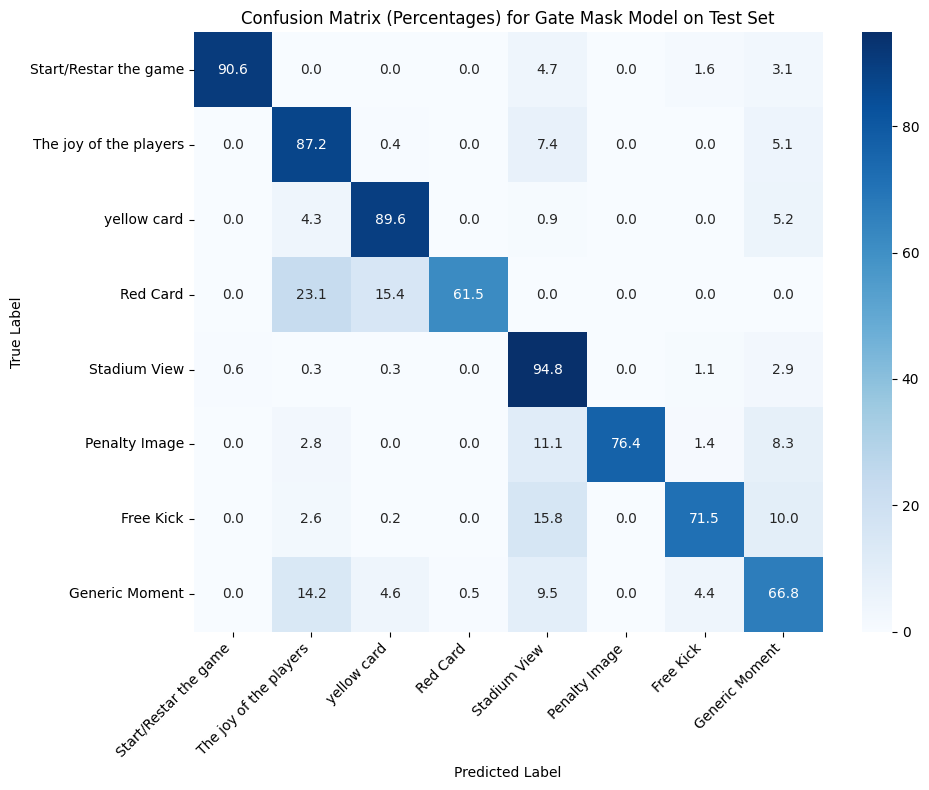

In [28]:

# ==== Compute Confusion Matrix ====
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) for Gate Mask Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('enhanced_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [29]:
# Convert to numpy arrays (if not already)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate per-class accuracy
class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

# Calculate class accuracies with proper handling of zero division
class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

# Calculate overall accuracy
overall_accuracy = sum(class_correct) / sum(class_total) * 100

# Print per-class accuracy as table
print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}")
print("-" * 35)
print(f"{'Overall':<25}{overall_accuracy:>9.2f}")


Class                      Accuracy
-----------------------------------
Start/Restar the game        90.62
The joy of the players       87.16
yellow card                  89.57
Red Card                     61.54
Stadium View                 94.85
Penalty Image                76.39
Free Kick                    71.46
Generic Moment               66.75
-----------------------------------
Overall                      82.05


In [30]:
# Weighted versions
weighted_precision = precision_score(all_labels, all_preds, average='weighted')
weighted_recall = recall_score(all_labels, all_preds, average='weighted')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print weighted metrics
print(f"Accuracy: {overall_accuracy/100:.3f}")
print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall: {weighted_recall:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")


Accuracy: 0.821
Weighted Precision: 0.827
Weighted Recall: 0.821
Weighted F1 Score: 0.818


---
## 3. Referee masked inputs

In [8]:
mask_path = 'data/Ref_Mask'

In [9]:
# Split dataset
train_dataset, test_dataset = train_test_split(labels, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)


train_data = MatchDatasetWithMask(train_dataset, image_path, mask_path, transform)
val_data = MatchDatasetWithMask(val_dataset, image_path, mask_path, transform)
test_data = MatchDatasetWithMask(test_dataset, image_path, mask_path, transform)


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
model = ResNet18With4Channels(len(LABELS))
model = model.to(device)

/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    model_save_path='models/resnet18_referee_masked.pth'
)

Training on device: cuda:0
Input shape will be: [batch_size, 4, 224, 224]


Input tensor shape: torch.Size([32, 4, 224, 224])


### **Evaluation metrics**

In [11]:
# ==== Load Best Enhanced Model ====
gatemask_model = ResNet18With4Channels(num_classes=len(LABELS))
gatemask_model.load_state_dict(torch.load('resnet18_referee_masked.pth'))
gatemask_model.to(device)
gatemask_model.eval()

# ==== Inference on Test Set ====
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


In [12]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)


                        precision    recall  f1-score   support

 Start/Restar the game      0.877     0.891     0.884        64
The joy of the players      0.879     0.763     0.817       257
           yellow card      0.874     0.843     0.858       115
              Red Card      0.833     0.385     0.526        13
          Stadium View      0.889     0.936     0.912       660
         Penalty Image      0.900     0.875     0.887        72
             Free Kick      0.917     0.819     0.865       431
        Generic Moment      0.699     0.802     0.747       388

              accuracy                          0.850      2000
             macro avg      0.859     0.789     0.812      2000
          weighted avg      0.856     0.850     0.850      2000



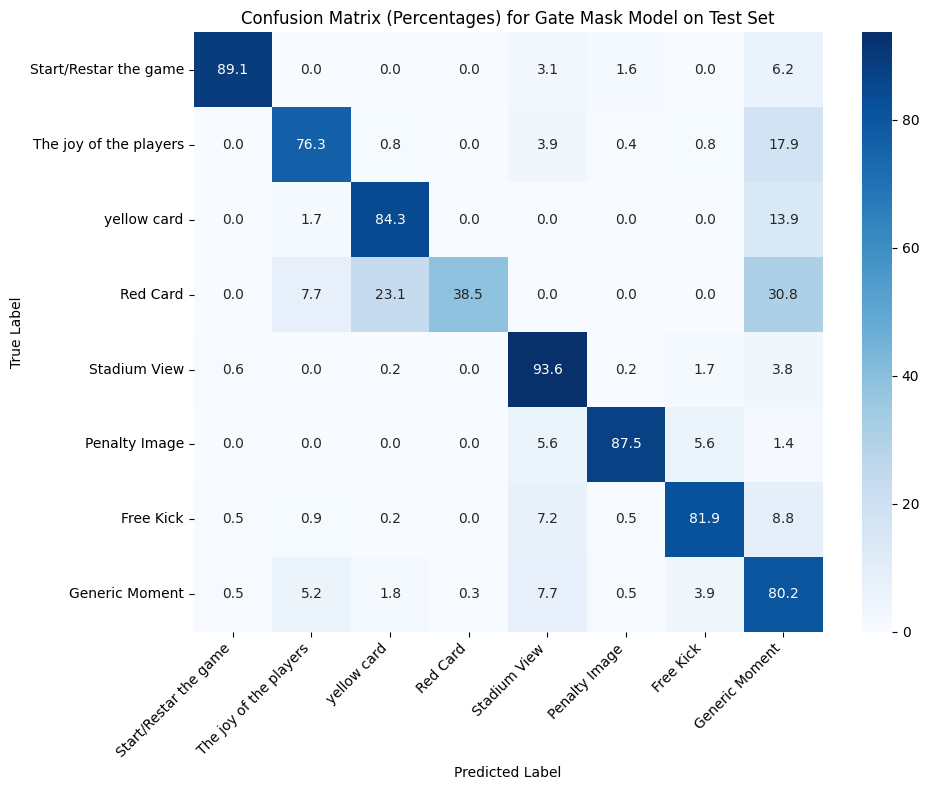

In [13]:

# ==== Compute Confusion Matrix ====
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) for Gate Mask Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('enhanced_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Convert to numpy arrays (if not already)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate per-class accuracy
class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

# Calculate class accuracies with proper handling of zero division
class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

# Calculate overall accuracy
overall_accuracy = sum(class_correct) / sum(class_total) * 100

# Print per-class accuracy as table
print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}")
print("-" * 35)
print(f"{'Overall':<25}{overall_accuracy:>9.2f}")


Class                      Accuracy
-----------------------------------
Start/Restar the game        89.06
The joy of the players       76.26
yellow card                  84.35
Red Card                     38.46
Stadium View                 93.64
Penalty Image                87.50
Free Kick                    81.90
Generic Moment               80.15
-----------------------------------
Overall                      85.00


In [15]:
# Weighted versions
weighted_precision = precision_score(all_labels, all_preds, average='weighted')
weighted_recall = recall_score(all_labels, all_preds, average='weighted')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print weighted metrics
print(f"Accuracy: {overall_accuracy/100:.3f}")
print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall: {weighted_recall:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")


Accuracy: 0.850
Weighted Precision: 0.856
Weighted Recall: 0.850
Weighted F1 Score: 0.850
